# Real vs. Fake Jobs



## Job Fraud Detection using Machine Learning

This notebook builds and compares multiple machine learning models to detect fraudulent job postings.  

We will first preprocess the data,then  engineer features, evaluate models using test metrics and cross-validation, and analyse the feature importance to select the most effective classifier.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

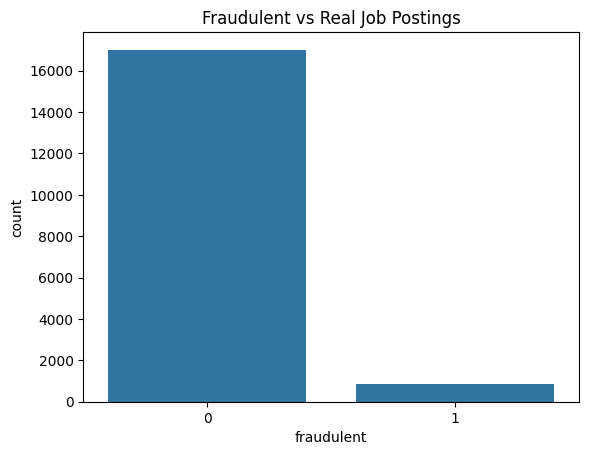

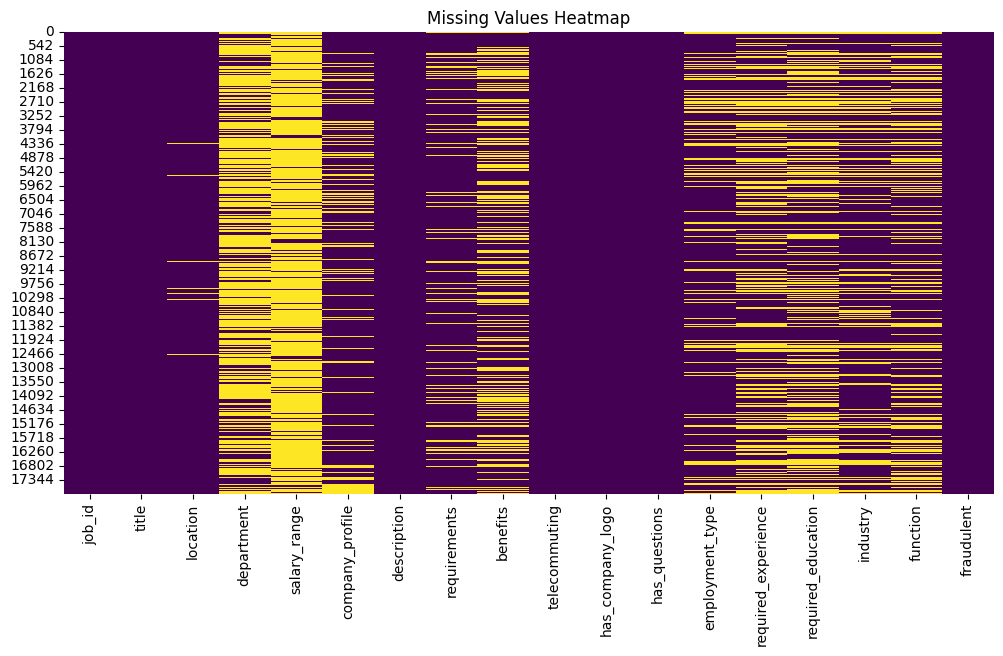


Top 10 titles:
title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: count, dtype: int64

Top 10 locations:
location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
US, TX, Houston          269
US, IL, Chicago          255
US, DC, Washington       251
DE, BE, Berlin           221
NZ, N, Auckland          218
Name: count, dtype: int64

Top 10 industrys:
industry


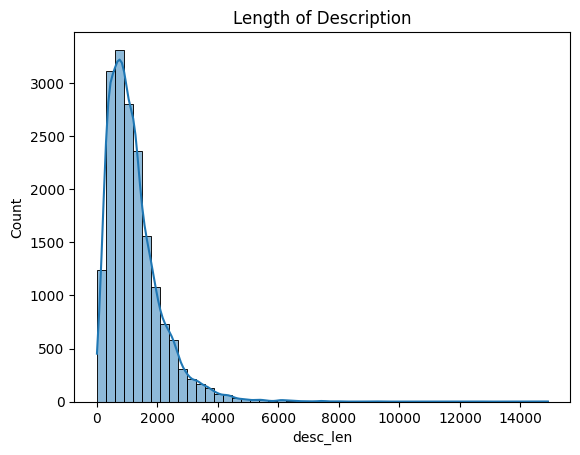

In [ ]:
#First we analyse the dataset

#  A. LOAD AND EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/shehryar/Business Analytics/Masters modules /SMM284/fake_job_postings.csv")

# Basic Info
print(df.info())
print(df["fraudulent"].value_counts(normalize=True))

# Visual: Class Distribution
sns.countplot(data=df, x="fraudulent")
plt.title("Fraudulent vs Real Job Postings")
plt.show()

# Missing Values
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Most common job titles / locations / industries
for col in ["title", "location", "industry"]:
    print(f"\nTop 10 {col}s:")
    print(df[col].value_counts().head(10))

# Length of description/requirements
df["desc_len"] = df["description"].fillna("").apply(len)
df["req_len"] = df["requirements"].fillna("").apply(len)

sns.histplot(df["desc_len"], bins=50, kde=True)
plt.title("Length of Description")
plt.show()


In [ ]:
# Preprocessing the data and setting up the pipeline

# Imports for data prep, modeling, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows where the target is missing, and fill other missing values with blanks
df = df.dropna(subset=["fraudulent"])
df.fillna("", inplace=True)

# Create two new numeric features: lengths of job description and requirements
df["desc_len"] = df["description"].apply(len)
df["req_len"] = df["requirements"].apply(len)

# Define feature matrix X and target vector y
X = df[["title", "location", "industry", "description", "requirements", "desc_len", "req_len"]]
y = df["fraudulent"]

# Split into train and test sets with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Combine description and requirements into one text field for TF-IDF processing
X_train["text_combined"] = X_train["description"] + " " + X_train["requirements"]
X_test["text_combined"] = X_test["description"] + " " + X_test["requirements"]

# Drop original columns — they are now redundant
X_train = X_train.drop(columns=["description", "requirements"])
X_test = X_test.drop(columns=["description", "requirements"])
# Create preprocessing pipelines for different feature types

# Pipeline for categorical features: impute missing, then one-hot encode
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", max_categories=20))
])

# Pipeline for text features: apply TF-IDF vectorization
text_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=3000))
])

# Pipeline for numeric features: scale using standard scaler
num_pipe = Pipeline([
    ("scaler", StandardScaler())
])

# Combine all preprocessing steps into a ColumnTransformer
preprocessor = ColumnTransformer([
    ("cat", cat_pipe, ["title", "location", "industry"]),      # Categorical
    ("txt", text_pipe, "text_combined"),                       # Text
    ("num", num_pipe, ["desc_len", "req_len"])                 # Numeric (engineered)
])

# Fit and transform the training data, and transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
# Extract feature names after fitting the preprocessor
ohe_features = preprocessor.named_transformers_["cat"]["ohe"].get_feature_names_out(["title", "location", "industry"])
tfidf_features = preprocessor.named_transformers_["txt"]["tfidf"].get_feature_names_out()
numeric_features = ["desc_len", "req_len"]

# Combine all feature names
feature_names = list(ohe_features) + list(tfidf_features) + numeric_features

# Check if it aligns with the model’s feature importances
print("Feature names length:", len(feature_names))
print("Random Forest importances length:", len(best_rf.feature_importances_))


# Balance the training data using random oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_processed, y_train)


Feature names length: 3062
Random Forest importances length: 3062


In [50]:
# Extract transformed feature names (after preprocessing)
def get_transformed_feature_names(preprocessor):
    cat_names = preprocessor.named_transformers_["cat"]["ohe"].get_feature_names_out(["title", "location", "industry"])
    tfidf_names = preprocessor.named_transformers_["txt"]["tfidf"].get_feature_names_out()
    return np.concatenate([cat_names, tfidf_names])

# Save to variable
feature_names = get_transformed_feature_names(preprocessor)

# Sanity check lengths
print("Feature names length:", len(feature_names))
print("Random Forest importances length:", len(best_rf.feature_importances_))


Feature names length: 3060
Random Forest importances length: 3062


In [53]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Now, we run and evalutate our models

#### Note on Naive Bayes

Naive Bayes was excluded from final model comparisons due to its inability to handle negative feature values, which arise from scaled numeric features like `desc_len` and `req_len`. Removing these features for Naive Bayes would have resulted in an inconsistent feature space compared to other models, making comparisons unfair.


Best Logistic Regression params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Random Forest params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


/opt/anaconda3/envs/smm750/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:51:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Logistic Regression ===
              precision    recall  f1-score   support

    Real (0)       0.99      0.99      0.99      3403
    Fake (1)       0.76      0.76      0.76       173

    accuracy                           0.98      3576
   macro avg       0.87      0.88      0.87      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC Score: 0.9663


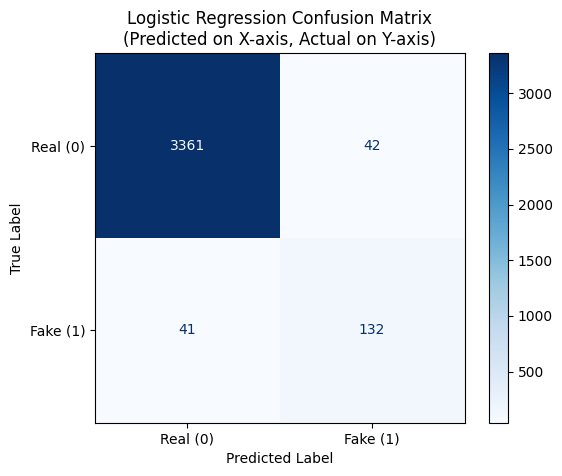


=== Random Forest ===
              precision    recall  f1-score   support

    Real (0)       0.98      1.00      0.99      3403
    Fake (1)       0.99      0.60      0.74       173

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC Score: 0.9797


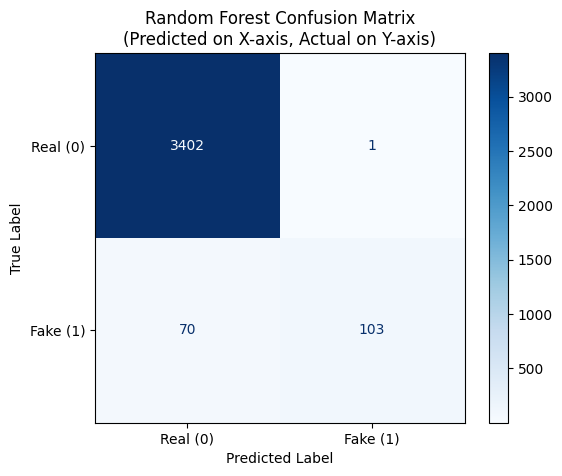


=== XGBoost ===
              precision    recall  f1-score   support

    Real (0)       0.99      0.99      0.99      3403
    Fake (1)       0.79      0.75      0.77       173

    accuracy                           0.98      3576
   macro avg       0.89      0.87      0.88      3576
weighted avg       0.98      0.98      0.98      3576

ROC-AUC Score: 0.9722


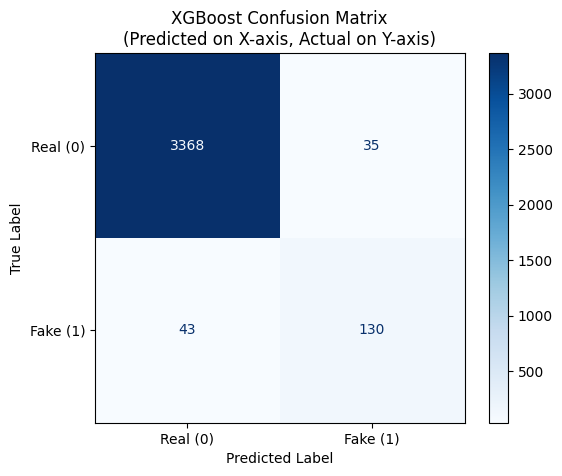

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === Logistic Regression (with tuning) ===
grid_logreg = GridSearchCV(LogisticRegression(), param_grid={
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}, cv=3, scoring='f1')
grid_logreg.fit(X_resampled, y_resampled)
best_logreg = grid_logreg.best_estimator_
print("Best Logistic Regression params:", grid_logreg.best_params_)

# === Random Forest (with tuning) ===
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid={
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}, cv=3, scoring='f1')
grid_rf.fit(X_resampled, y_resampled)
best_rf = grid_rf.best_estimator_
print("Best Random Forest params:", grid_rf.best_params_)

# === XGBoost (manually tuned) ===
best_xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
best_xgb.fit(X_resampled, y_resampled)

# === Naive Bayes (with tuning) ===
#grid_nb = GridSearchCV(MultinomialNB(), param_grid={
#    'alpha': [0.01, 0.1, 1.0]
#}, cv=3, scoring='f1')
#grid_nb.fit(X_resampled, y_resampled)
##best_nb = grid_nb.best_estimator_
#print("Best Naive Bayes params:", grid_nb.best_params_)

# === Model Dictionary ===
models = {
    "Logistic Regression": best_logreg,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    #"Naive Bayes": best_nb
}

# === Evaluation Loop ===
for name, model in models.items():
    # Predict class labels
    y_pred = model.predict(X_test_processed)

    # Predict probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_processed)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        # Some models (like SVM without probability) may not support predict_proba
        auc = None

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=["Real (0)", "Fake (1)"]))
    if auc is not None:
        print(f"ROC-AUC Score: {auc:.4f}")
    else:
        print("ROC-AUC not available for this model.")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real (0)", "Fake (1)"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} Confusion Matrix\n(Predicted on X-axis, Actual on Y-axis)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()



In [55]:
X_test.describe(include='all')

,title,location,industry,desc_len,req_len,text_combined
count,3576,3576,3576,3576.000000,3576.000000,3576
unique,2777,1177,117,NaN,NaN,3316
top,English Teacher Abroad,"GB, LND, London",,NaN,NaN,"Play with kids, get paid for it Love travel? J..."
freq,49,139,977,NaN,NaN,71
mean,NaN,NaN,NaN,1244.482383,587.503915,NaN
std,NaN,NaN,NaN,918.665276,600.665943,NaN
min,NaN,NaN,NaN,50.000000,0.000000,NaN
25%,NaN,NaN,NaN,623.000000,140.000000,NaN
50%,NaN,NaN,NaN,1043.500000,469.500000,NaN
75%,NaN,NaN,NaN,1594.250000,813.250000,NaN


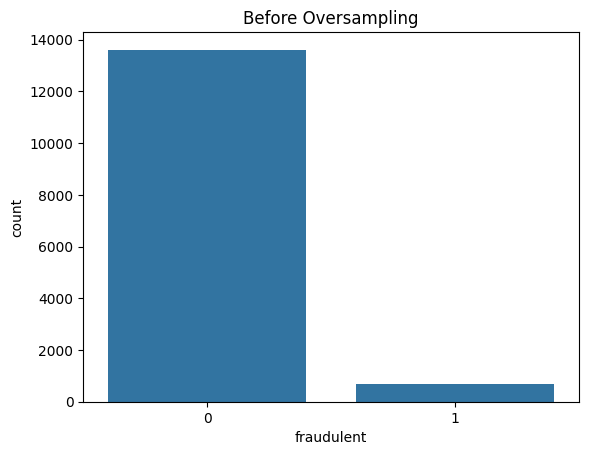

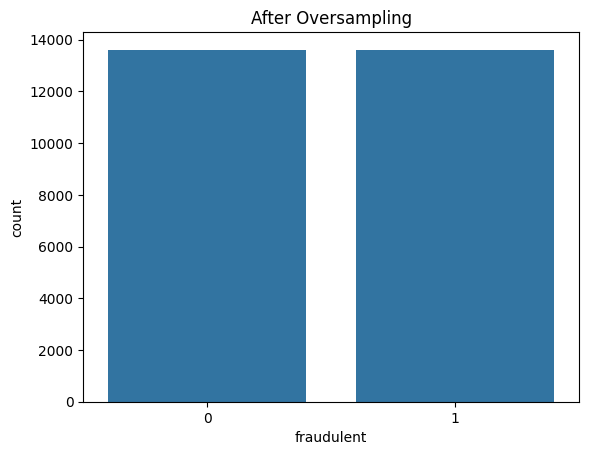

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train)
plt.title("Before Oversampling")
plt.show()

sns.countplot(x=y_resampled)
plt.title("After Oversampling")
plt.show()


## Comparison Table of the Models 

In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Create list to store performance results
results = []

for name, model in models.items():
    # Predict class labels
    y_pred = model.predict(X_test_processed)

    # Predict probabilities if supported (for ROC-AUC)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_processed)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = float('nan')  # Use NaN instead of None for DataFrame compatibility

    # Append metrics to list
    results.append({
        "Model": name,
        "F1 Score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "ROC-AUC": auc
    })

# Create DataFrame and sort
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)

# Round for display
results_df = results_df.round(4)

# Display results
display(results_df)


,Model,F1 Score,Precision,Recall,ROC-AUC
2,XGBoost,0.7692,0.7879,0.7514,0.9722
0,Logistic Regression,0.7608,0.7586,0.7630,0.9663
1,Random Forest,0.7437,0.9904,0.5954,0.9797


## Now we plot ROC Curves

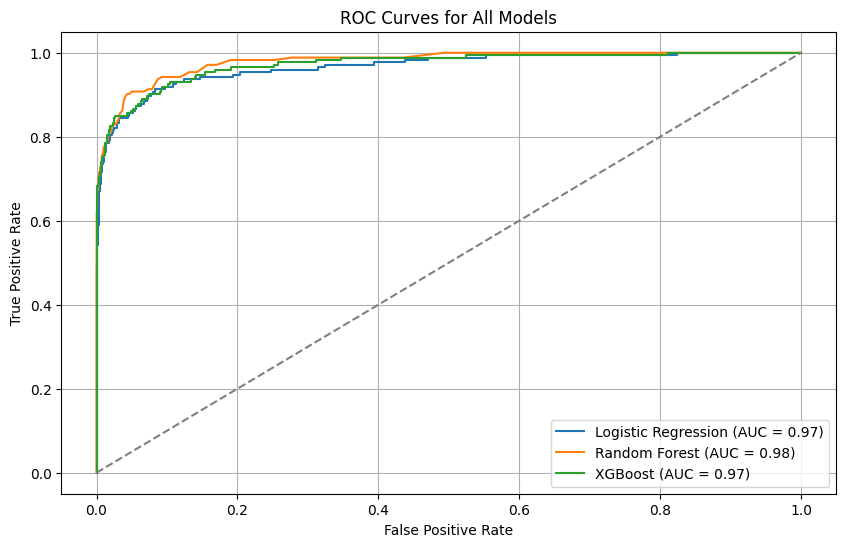

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Initialize a plot
plt.figure(figsize=(10, 6))

# Loop through each model
for name, model in models.items():
    # Predict probabilities for the positive class
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_processed)[:, 1]  # Probabilities for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    else:
        print(f"{name} doesn't support predict_proba")

# Plot the diagonal line (no discrimination)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Model Evaluation Summary (Test Set)

The performance of three classification models was assessed using key metrics: **F1 Score**, **Precision**, **Recall**, and **ROC-AUC**. 

### ROC Curve Insights

The ROC curves (shown below) demonstrate that all models perform very well in distinguishing between fraudulent and real job postings, with **AUC scores between 0.966 and 0.980**.

-  **Random Forest** achieved the **highest ROC-AUC (0.9797)**, indicating strong discrimination. However, its **low recall (0.5954)** means it misses many fraudulent cases.
-  **Logistic Regression** had the **highest recall (0.7630)**, showing sensitivity to fraudulent postings, but slightly lower precision.
-  **XGBoost** showed the **most balanced performance**, combining a strong F1 score, high AUC, and a solid trade-off between precision and recall.



### Initial Best Model

From a test set perspective:
- **XGBoost emerges as the most effective model overall**, offering well-rounded performance across all metrics.
- While Random Forest excels at precision and AUC, its lower recall is concerning in a fraud detection context.
- Logistic Regression is competitive, particularly in recall, but XGBoost edges it out in overall F1 and balance.

> These conclusions are based on a single test set split. In the next step, we’ll validate robustness and generalizability via **cross-validation**.


## Now We conduct Cross Validation

In [59]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

# Loop through each model
for name, model in models.items():
    scores = cross_val_score(model, X_resampled, y_resampled, scoring='f1', cv=skf)
    cv_results.append({
        "Model": name,
        "CV Mean F1": scores.mean(),
        "CV Std F1": scores.std()
    })

# Create and display CV results
cv_df = pd.DataFrame(cv_results).sort_values(by="CV Mean F1", ascending=False)
cv_df = cv_df.round(4)
display(cv_df)



/opt/anaconda3/envs/smm750/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:57:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/smm750/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:57:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/smm750/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:57:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/smm750/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:57:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" }

,Model,CV Mean F1,CV Std F1
1,Random Forest,0.9993,0.0003
2,XGBoost,0.9930,0.0006
0,Logistic Regression,0.9841,0.0010


## Feature analysis for each model

In [60]:
# Get feature names from column transformer
# Extract feature names from ColumnTransformer
cat_features = preprocessor.named_transformers_['cat']['ohe'].get_feature_names_out(["title", "location", "industry"])
txt_features = preprocessor.named_transformers_['txt']['tfidf'].get_feature_names_out()
num_features = ["desc_len", "req_len"]

feature_names = list(cat_features) + list(txt_features) + num_features



/var/folders/mj/tdy0190s2f99p6905r2nbflh0000gn/T/ipykernel_35455/2859865161.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_df, x="Importance", y="Feature", palette="viridis")


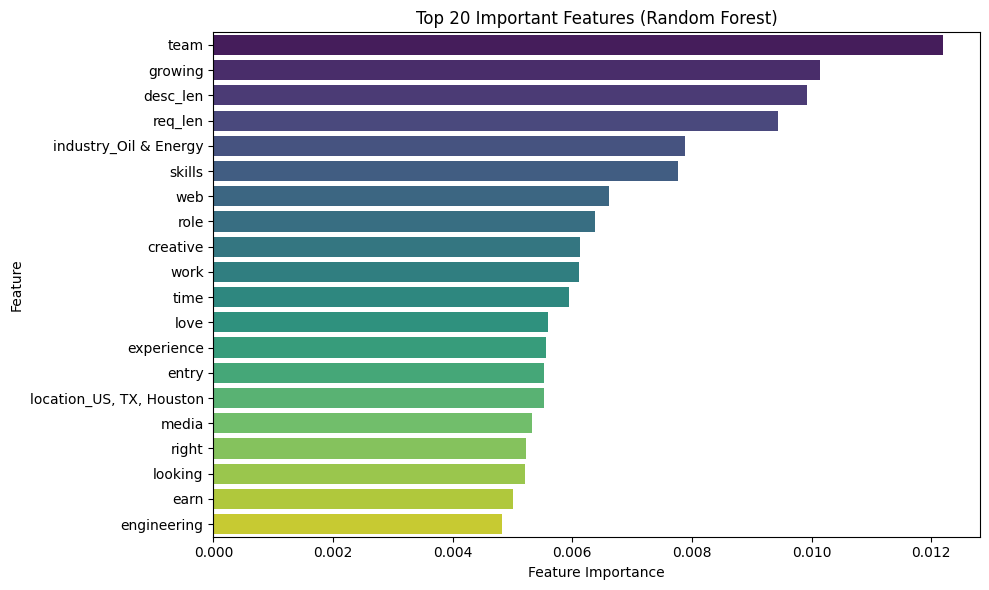

In [61]:
### First we conduct it for Random Forest 
import pandas as pd
import matplotlib.pyplot as plt

# Random Forest Feature Importance
rf_importances = best_rf.feature_importances_

rf_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_importances
}).sort_values(by="Importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_df, x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()







/var/folders/mj/tdy0190s2f99p6905r2nbflh0000gn/T/ipykernel_35455/2735663058.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_df, x="Importance", y="Feature", palette="magma")


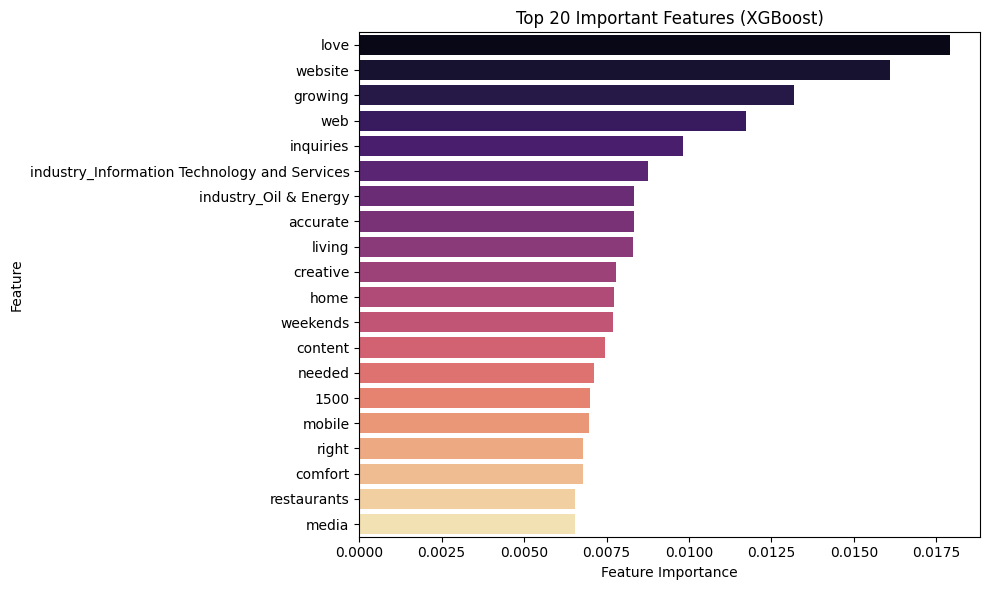

In [62]:
# XGBoost Feature Importance
xgb_importances = best_xgb.feature_importances_

xgb_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": xgb_importances
}).sort_values(by="Importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_df, x="Importance", y="Feature", palette="magma")
plt.title("Top 20 Important Features (XGBoost)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

/var/folders/mj/tdy0190s2f99p6905r2nbflh0000gn/T/ipykernel_35455/3116697260.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_logreg, x="Coefficient", y="Feature", palette="coolwarm")


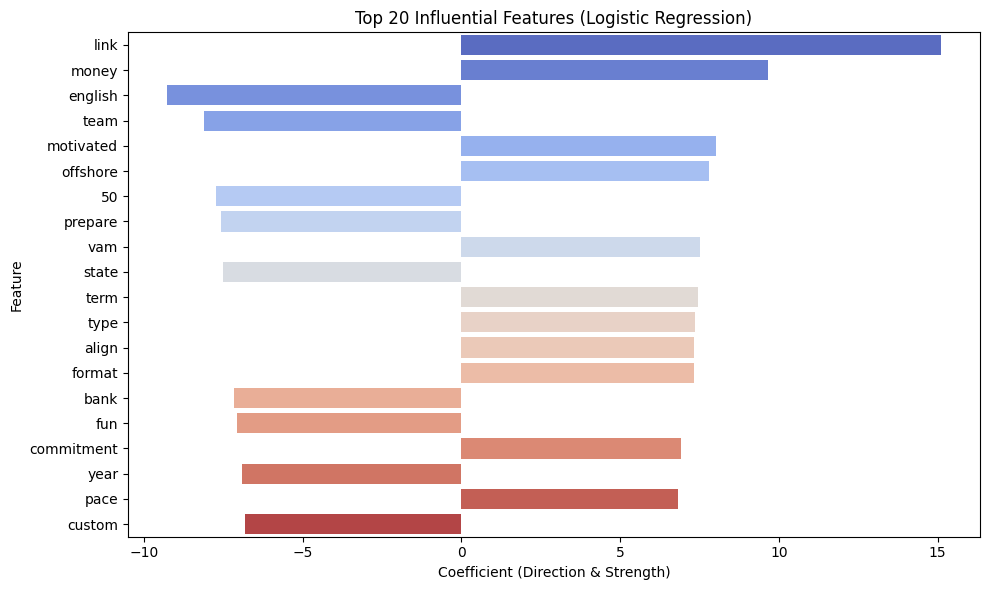

In [63]:
## No, feature analysis for Logistic regression: 
import numpy as np

# Coefficients for Logistic Regression
logreg_coefs = best_logreg.coef_[0]  # For binary classification, there's only one row

logreg_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": logreg_coefs
})

# Add magnitude for sorting
logreg_df["Importance"] = np.abs(logreg_df["Coefficient"])

# Top 20 influential features (absolute value)
top_logreg = logreg_df.sort_values(by="Importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_logreg, x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Top 20 Influential Features (Logistic Regression)")
plt.xlabel("Coefficient (Direction & Strength)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Model Evaluation (Test Set)

The performance of three classification models was evaluated using the test set, focusing on four key metrics: **F1 Score**, **Precision**, **Recall**, and **ROC-AUC**.

---

## ROC Curve Analysis

The ROC curves show all models are effective at separating fraudulent from legitimate job posts. AUC values range from **0.966 to 0.980**, indicating strong discriminative power.

- **Random Forest** had the highest AUC (0.9797) but suffered from low recall (0.5954), meaning many fraudulent cases were missed.
- **Logistic Regression** achieved the **highest recall (0.7630)**, making it more sensitive to fraud, but slightly lower in precision.
- **XGBoost** provided the most **balanced performance**, with a strong F1 score, high precision and recall, and an AUC of **0.9722**.



## Cross-Validation Results

To validate generalizability, 5-fold stratified cross-validation was conducted, which showed that Random Forest appeared to overfit (high CV F1 but lower test recall), while XGBoost maintained both **strong cross-validated performance and test generalization**.



## Feature Importance Analysis

### Top 20 Features by Model:

#### XGBoost:
- High importance for words like: **"love"**, **"website"**, **"growing"**, **"web"**
- Key industries: **Information Technology**, **Oil & Energy**

#### Random Forest:
- Strong importance for: **"team"**, **"growing"**, as well as engineered features like **`desc_len`** and **`req_len`**

#### Logistic Regression:
- Top positive fraud indicators: **“link”, “money”, “offshore”, “english”**
- Top legitimate indicators: **“custom”, “pace”, “commitment”, “fun”**

This reinforces the value of **textual signals**, **domain-specific words**, and **length-based features** in detecting fraudulent job postings.



## Final Model Selection

Taking into account:
- Test metrics (F1, Recall, AUC)
- Cross-validation stability
- Feature importance interpretability

**XGBoost** is selected as the final model due to its **balanced performance**, **generalization**, and **robust feature handling**.


## Future Work

- **Probability calibration** for threshold-based decision-making
- **Outlier detection** to clean training data
- **Hyperparameter tuning** for even stronger performance

